# WPs cleanup

In [1]:
from simsopt._core import load
from simsopt.geo import SurfaceRZFourier
from simsopt.geo import new_windowpane_curve_on_max_error
from simsopt.geo import OrientedCurveXYZFourier
from simsopt.field.coil import apply_symmetries_to_curves, apply_symmetries_to_currents, Current, Coil, ScaledCurrent
from simsopt.field import BiotSavart
from simsopt.geo.curveobjectives import CurveLength, CurveCurveDistance, \
    MeanSquaredCurvature, LpCurveCurvature, CurveSurfaceDistance, LinkingNumber
from simsopt.objectives import SquaredFlux, QuadraticPenalty

import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import minimize

%matplotlib widget

In [2]:
mydir = 'output/run_01'

bs = load(os.path.join(mydir, 'biotsavart_final.json'))
surf = SurfaceRZFourier.from_vmec_input('input.LandremanPaul2021_QH')

surf.fix_all()
for c in bs.coils:
    c.curve.fix_all()
    c.current.unfix_all()

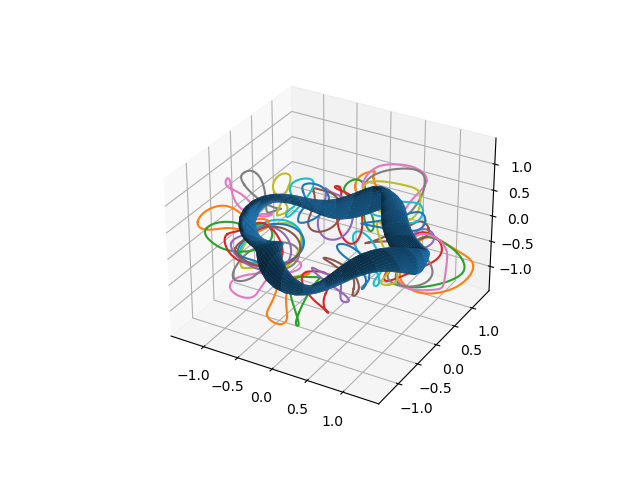

In [3]:
surf.plot(close=True, show=False)
ax = plt.gca()
for c in bs.coils:
    c.curve.plot(ax=ax, show=False)

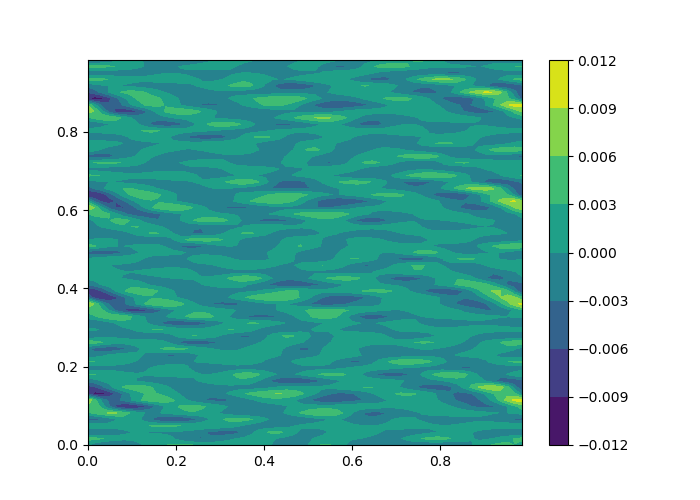

In [4]:
theta = surf.quadpoints_theta
phi = surf.quadpoints_phi
ntheta = theta.size
nphi = phi.size
bs.set_points(surf.gamma().reshape((-1,3)))
Bdotn = np.sum(bs.B().reshape((nphi, ntheta, 3)) * surf.unitnormal(), axis=2)
modB = bs.AbsB().reshape((nphi,ntheta))

fig, ax = plt.subplots(figsize=(7,5))
c = ax.contourf(theta,phi,Bdotn / modB)
plt.colorbar(c)

In [5]:
order = 2

wp_curve1 = OrientedCurveXYZFourier( 32, order )
wp_curve1.set('x0',1.4)
wp_curve1.set('y0',0.25)
wp_curve1.set('z0',0.2)
wp_curve1.set('yc(1)',0.5)
wp_curve1.set('zs(1)',0.5)
wp_curve1.set('yaw', -0.35)
wp_curve1.unfix_all()

wp_curve2 = OrientedCurveXYZFourier( 32, order )
wp_curve2.set('x0',1.4)
wp_curve2.set('y0',-0.25)
wp_curve2.set('z0',0.2)
wp_curve2.set('yc(1)',0.5)
wp_curve2.set('zs(1)',0.5)
wp_curve2.set('yaw', 0.35)
wp_curve2.unfix_all()

base_wp_curves = [wp_curve1, wp_curve2]
wp_curves = apply_symmetries_to_curves( base_wp_curves, surf.nfp, True)


wp_current1 = ScaledCurrent(Current(1), 1e4)
wp_current2 = ScaledCurrent(Current(1), 1e4)
wp_current1.unfix_all()
wp_current2.unfix_all()
wp_currents = apply_symmetries_to_currents( [wp_current1, wp_current2], surf.nfp, True)

wp_coils = [Coil(curve, current) for curve, current in zip(wp_curves, wp_currents)]

tf_coils = bs.coils
full_coils = tf_coils + wp_coils
full_curves = [c.curve for c in full_coils]
bs = BiotSavart(full_coils)

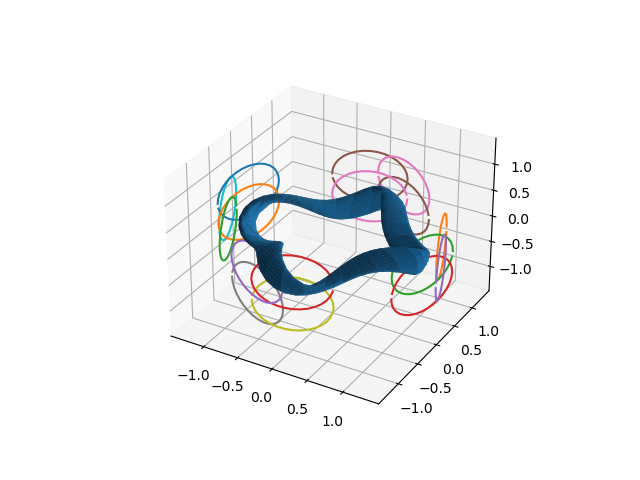

In [6]:
surf.plot(close=True, show=False)
ax = plt.gca()
# for c in bs.coils:
#     c.curve.plot(ax=ax, show=False)
for c in wp_curves:
    c.plot(ax=ax,show=False)

In [7]:
# Weight on the curve lengths in the objective function. We use the `Weight`
# class here to later easily adjust the scalar value and rerun the optimization
# without having to rebuild the objective.
LENGTH_WEIGHT = 1E-12

# Threshold and weight for the coil-to-coil distance penalty in the objective function:
CC_THRESHOLD = 0.08
CC_WEIGHT = 0.0

# Threshold and weight for the coil-to-surface distance penalty in the objective function:
CS_THRESHOLD = 0.12
CS_WEIGHT = 0.0

# Threshold and weight for the curvature penalty in the objective function:
CURVATURE_THRESHOLD = 12.
CURVATURE_WEIGHT = 0.0

# Threshold and weight for the mean squared curvature penalty in the objective function:
MSC_THRESHOLD = 11
MSC_WEIGHT = 0.0 

Jf = SquaredFlux(surf, bs)
Jls = [CurveLength(c) for c in wp_curves]
Jccdist = CurveCurveDistance(full_curves, CC_THRESHOLD, num_basecurves=len(full_curves))
Jcsdist = CurveSurfaceDistance(base_wp_curves, surf, CS_THRESHOLD)
Jcs = [LpCurveCurvature(c, 2, CURVATURE_THRESHOLD) for c in wp_curves]
Jmscs = [MeanSquaredCurvature(c) for c in wp_curves]
JF = Jf \
    + LENGTH_WEIGHT * QuadraticPenalty(sum(Jls), 20.0) \
    + CC_WEIGHT * Jccdist \
    + CS_WEIGHT * Jcsdist 
    #+ CURVATURE_WEIGHT * sum(Jcs) \
    #+ MSC_WEIGHT * sum(QuadraticPenalty(J, MSC_THRESHOLD) for J in Jmscs) \
    #+ QuadraticPenalty(linkNum, 0.1) 

In [8]:
def fun(dofs):
    JF.x = dofs
    J = JF.J()
    grad = JF.dJ()
    jf = Jf.J()
    BdotN = np.mean(np.abs(np.sum(bs.B().reshape((nphi, ntheta, 3)) * surf.unitnormal(), axis=2)))
    MaxBdotN = np.max(np.abs(np.sum(bs.B().reshape((nphi, ntheta, 3)) * surf.unitnormal(), axis=2)))
    mean_AbsB = np.mean(bs.AbsB())

    
    outstr = f"J={J:.1e}, Jf={jf:.1e}, ⟨B·n⟩={BdotN:.1e}"
    cl_string = ", ".join([f"{J.J():.1f}" for J in Jls])
    kap_string = ", ".join(f"{np.max(c.kappa()):.1f}" for c in full_curves)
    msc_string = ", ".join(f"{J.J():.1f}" for J in Jmscs)
    outstr += f", Len=sum([{cl_string}])={sum(J.J() for J in Jls):.1f}, ϰ=[{kap_string}], ∫ϰ²/L=[{msc_string}]"
    outstr += f", C-C-Sep={Jccdist.shortest_distance():.2f}, C-S-Sep={Jcsdist.shortest_distance():.2f}"
    outstr += f", ║∇J║={np.linalg.norm(grad):.1e}"
    outstr += f", ⟨B·n⟩/|B|={BdotN/mean_AbsB:.1e}"
    outstr += f", (Max B·n)/|B|={MaxBdotN/mean_AbsB:.1e}"
    print(outstr)
    return J, grad

In [9]:
x = JF.x
fun(x)

J=7.3e-05, Jf=7.3e-05, ⟨B·n⟩=3.4e-03, Len=sum([3.1, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1])=50.3, ϰ=[6.1, 8.6, 8.1, 6.6, 6.2, 6.1, 8.6, 8.1, 6.6, 6.2, 6.1, 8.6, 8.1, 6.6, 6.2, 6.1, 8.6, 8.1, 6.6, 6.2, 6.1, 8.6, 8.1, 6.6, 6.2, 6.1, 8.6, 8.1, 6.6, 6.2, 6.1, 8.6, 8.1, 6.6, 6.2, 6.1, 8.6, 8.1, 6.6, 6.2, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0], ∫ϰ²/L=[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0], C-C-Sep=0.02, C-S-Sep=0.23, ║∇J║=8.5e-04, ⟨B·n⟩/|B|=5.4e-02, (Max B·n)/|B|=2.1e-01


(Array(7.28800662e-05, dtype=float64),
 array([-5.10120257e-10, -2.33053261e-09,  8.62250394e-10,  1.53585772e-09,
         4.33447172e-10,  3.67898516e-05,  1.08878389e-04, -5.54079532e-05,
        -9.84923510e-05,  4.36865247e-04,  2.53418714e-05,  4.04022034e-05,
        -1.47479557e-05, -8.60195382e-05,  5.06837428e-05,  3.51156080e-05,
        -9.28961784e-05, -2.18315194e-05,  7.81776404e-05,  1.73542325e-04,
        -5.51270245e-05, -2.64841649e-04, -2.18315190e-05, -1.83947369e-05,
        -2.63322921e-04, -3.25282603e-04,  2.39128200e-05,  3.26368330e-04,
        -6.68993488e-06,  2.80505380e-05,  1.02392465e-05, -5.97218504e-05,
        -1.33798698e-05,  8.33703329e-06, -7.09578465e-05,  4.55118439e-05,
         2.51097420e-05,  1.77802199e-04,  1.45828477e-06, -1.37879875e-04,
         4.55118423e-05, -9.05339218e-05, -1.48566132e-04]))

In [10]:
JF.dof_names

['Current1:x0',
 'Current2:x0',
 'Current3:x0',
 'Current4:x0',
 'Current5:x0',
 'Current6:x0',
 'Current7:x0',
 'OrientedCurveXYZFourier1:x0',
 'OrientedCurveXYZFourier1:y0',
 'OrientedCurveXYZFourier1:z0',
 'OrientedCurveXYZFourier1:yaw',
 'OrientedCurveXYZFourier1:pitch',
 'OrientedCurveXYZFourier1:roll',
 'OrientedCurveXYZFourier1:xs(1)',
 'OrientedCurveXYZFourier1:xc(1)',
 'OrientedCurveXYZFourier1:xs(2)',
 'OrientedCurveXYZFourier1:xc(2)',
 'OrientedCurveXYZFourier1:ys(1)',
 'OrientedCurveXYZFourier1:yc(1)',
 'OrientedCurveXYZFourier1:ys(2)',
 'OrientedCurveXYZFourier1:yc(2)',
 'OrientedCurveXYZFourier1:zs(1)',
 'OrientedCurveXYZFourier1:zc(1)',
 'OrientedCurveXYZFourier1:zs(2)',
 'OrientedCurveXYZFourier1:zc(2)',
 'OrientedCurveXYZFourier2:x0',
 'OrientedCurveXYZFourier2:y0',
 'OrientedCurveXYZFourier2:z0',
 'OrientedCurveXYZFourier2:yaw',
 'OrientedCurveXYZFourier2:pitch',
 'OrientedCurveXYZFourier2:roll',
 'OrientedCurveXYZFourier2:xs(1)',
 'OrientedCurveXYZFourier2:xc(1)',
 '

In [11]:
dofs = JF.x
res = minimize(fun, dofs, jac=True, method='L-BFGS-B', options={'maxiter': 1e3, 'maxcor': 300}, tol=1e-12)

J=7.3e-05, Jf=7.3e-05, ⟨B·n⟩=3.4e-03, Len=sum([3.1, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1])=50.3, ϰ=[6.1, 8.6, 8.1, 6.6, 6.2, 6.1, 8.6, 8.1, 6.6, 6.2, 6.1, 8.6, 8.1, 6.6, 6.2, 6.1, 8.6, 8.1, 6.6, 6.2, 6.1, 8.6, 8.1, 6.6, 6.2, 6.1, 8.6, 8.1, 6.6, 6.2, 6.1, 8.6, 8.1, 6.6, 6.2, 6.1, 8.6, 8.1, 6.6, 6.2, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0], ∫ϰ²/L=[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0], C-C-Sep=0.02, C-S-Sep=0.23, ║∇J║=8.5e-04, ⟨B·n⟩/|B|=5.4e-02, (Max B·n)/|B|=2.1e-01
J=6.1e-05, Jf=6.1e-05, ⟨B·n⟩=3.3e-03, Len=sum([4.8, 4.1, 4.8, 4.1, 4.8, 4.1, 4.8, 4.1, 4.8, 4.1, 4.8, 4.1, 4.8, 4.1, 4.8, 4.1])=70.8, ϰ=[6.1, 8.6, 8.1, 6.6, 6.2, 6.1, 8.6, 8.1, 6.6, 6.2, 6.1, 8.6, 8.1, 6.6, 6.2, 6.1, 8.6, 8.1, 6.6, 6.2, 6.1, 8.6, 8.1, 6.6, 6.2, 6.1, 8.6, 8.1, 6.6, 6.2, 6.1, 8.6, 8.1, 6.6, 6.2, 6.1, 8.6, 8.1, 6.6, 6.2, 23.3, 13.8, 23.3, 13.8, 23.3, 13.8, 23.3, 13.8, 23.3, 13.8, 23.3, 13.8, 23

In [12]:
res.message

'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

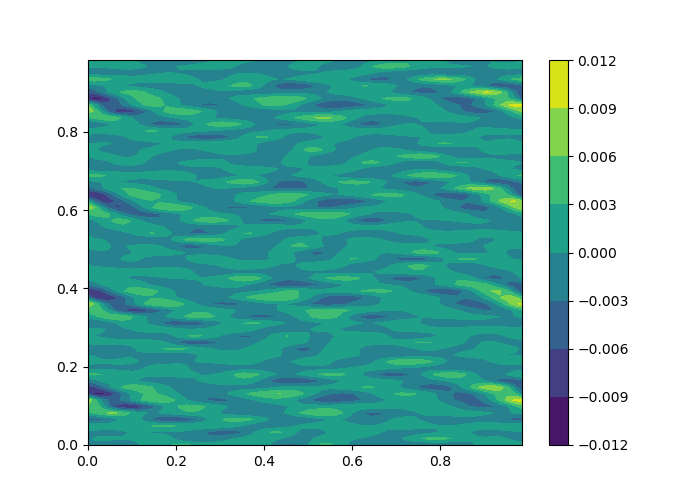

In [13]:
theta = surf.quadpoints_theta
phi = surf.quadpoints_phi
ntheta = theta.size
nphi = phi.size
bs.set_points(surf.gamma().reshape((-1,3)))
Bdotn = np.sum(bs.B().reshape((nphi, ntheta, 3)) * surf.unitnormal(), axis=2)
modB = bs.AbsB().reshape((nphi,ntheta))

fig, ax = plt.subplots(figsize=(7,5))
c = ax.contourf(theta,phi,Bdotn / modB)
plt.colorbar(c)

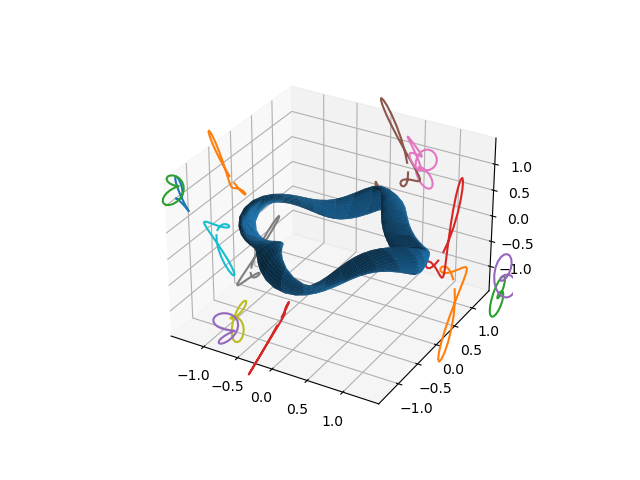

In [14]:
surf.plot(close=True, show=False)
ax = plt.gca()
# for c in bs.coils:
#     c.curve.plot(ax=ax, show=False)
for c in wp_curves:
    c.plot(ax=ax,show=False)

In [15]:
wp_current1.get_value()

7708.256392980055